In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [ ]:
pip install opencv-python


In [ ]:
# 1. Importing Libraries

In [3]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

# 2. Data Preparation

In [5]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('/Users/sunkarabhavana/Downloads/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('/Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)   

,dirname,filename
0,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation,.DS_Store
162,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-0.nii
163,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-1.nii
132,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-10.nii
180,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-100.nii
...,...,...
228,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2,volume-95.nii
219,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2,volume-96.nii
226,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2,volume-97.nii
188,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2,volume-98.nii


In [7]:
# Map CT scan and label 


df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/volume_pt1,volume-0.nii,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/volume_pt1,volume-1.nii,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/volume_pt1,volume-10.nii,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2,volume-100.nii,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/volume_pt2,volume-11.nii,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-11.nii
...,...,...,...,...
96,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2,volume-95.nii,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-95.nii
97,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2,volume-96.nii,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-96.nii
98,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2,volume-97.nii,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-97.nii
99,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2,volume-98.nii,/Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations,segmentation-98.nii


# 3. Data Preprocessing

In [9]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [11]:
# Read sample

sample = 40
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 119)
Mask Shape: (512, 512, 119)


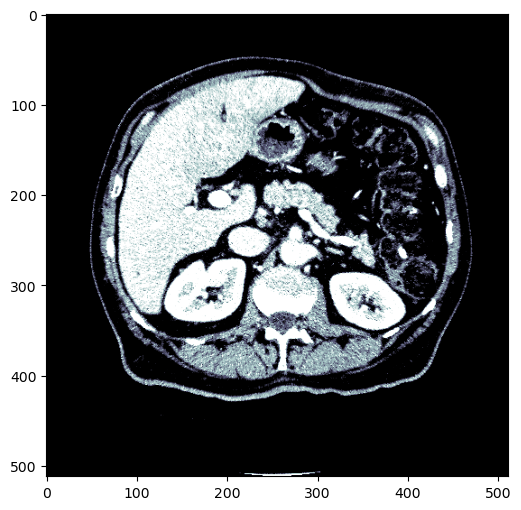

In [13]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

# Data Visualization
## Display Sample Images

In [15]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

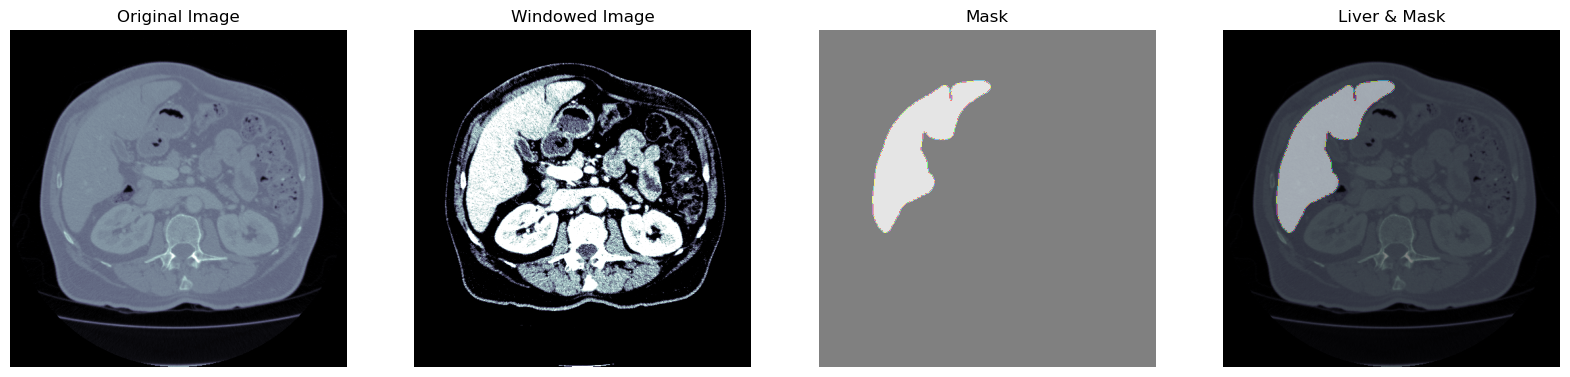

In [17]:
sample = 45

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

<Axes: >

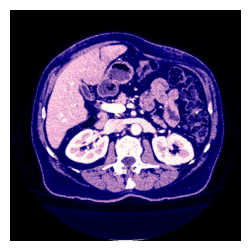

In [19]:
# Preprocessing functions
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'} #a subclass of a PyTorch Tensor designed to handle black-and-white images.

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)


@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120): #unction to convert the tensor to a multi-channel image suitable for saving as a JPG.The image is saved with the specified quality.
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

# 4. Generate Training Image From 'nii' File

In [21]:
from sklearn.model_selection import train_test_split

GENERATE_JPG_FILES = True

if GENERATE_JPG_FILES:

    path = Path(".")

    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)

    ## test folder
    os.makedirs('test_images', exist_ok=True)
    os.makedirs('test_masks', exist_ok=True)

    # Split the data into train and test sets
    train_df, test_df = train_test_split(df_files, test_size=0.1, random_state=42)

    # Check if train_df is empty
    print("Length of train_df:", len(train_df))

    # Reset index for contiguous indices
    train_df = train_df.reset_index(drop=True)
    # Check if test_df is empty
    print("Length of test_df:", len(test_df))
    test_df = test_df.reset_index(drop=True)

    # Loop for training set
    for ii in tqdm(range(len(train_df))):
        curr_ct = read_nii(train_df.loc[ii, 'dirname'] + "/" + train_df.loc[ii, 'filename'])
        curr_mask = read_nii(train_df.loc[ii, 'mask_dirname'] + "/" + train_df.loc[ii, 'mask_filename'])
        curr_file_name = str(train_df.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]

        for curr_slice in range(0, curr_dim, 2):
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")

    ### test image save
    for ii in tqdm(range(len(test_df))):
        curr_ct = read_nii(test_df.loc[ii, 'dirname'] + "/" + test_df.loc[ii, 'filename'])
        curr_mask = read_nii(test_df.loc[ii, 'mask_dirname'] + "/" + test_df.loc[ii, 'mask_filename'])
        curr_file_name = str(test_df.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]

        for curr_slice in range(0, curr_dim, 2):
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"test_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"test_masks/{curr_file_name}_slice_{curr_slice}_mask.png")

else:
    path = Path("../input/liver-segmentation-with-fastai-v2")  # read jpg from saved kernel output

Length of train_df: 90
Length of test_df: 11


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

## 4.1 - Check Data

In [23]:
print("\nFirst few rows of Training Set:")
print(train_df.head())

print("\nFirst few rows of Testing Set:")
print(test_df.head())


First few rows of Training Set:
                                                               dirname  \
0  /Users/sunkarabhavana/Downloads/liver-tumor-segmentation/volume_pt4   
1      /Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2   
2  /Users/sunkarabhavana/Downloads/liver-tumor-segmentation/volume_pt4   
3      /Users/sunkarabhavana/Downloads/liver-tumor-segmentation-part-2   
4  /Users/sunkarabhavana/Downloads/liver-tumor-segmentation/volume_pt2   

        filename  \
0  volume-35.nii   
1  volume-96.nii   
2  volume-38.nii   
3  volume-78.nii   
4  volume-11.nii   

                                                             mask_dirname  \
0  /Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations   
1  /Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations   
2  /Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations   
3  /Users/sunkarabhavana/Downloads/liver-tumor-segmentation/segmentations   
4  /Users/sunkar

In [25]:
print("\ntrain df data shape:")
print(train_df.shape)


train df data shape:
(90, 4)


In [27]:
print("\ntest df data shape:")
print(test_df.shape)


test df data shape:
(11, 4)


# 5. Resizing Images

In [37]:
# Set the directories
train_images_dir = '/Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/train_images'
train_masks_dir = '/Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/train_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(train_images_dir))

# Determine the sample size
sample_size = min(9000, len(all_image_file_names))

# Randomly select images
selected_image_file_names = random.sample(all_image_file_names, sample_size)

# Load selected images and masks with resizing nd converted to numpy arrays
target_size = (128, 128)
train_images = [np.array(Image.open(os.path.join(train_images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks 
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
train_masks = [np.array(Image.open(os.path.join(train_masks_dir, fname)).resize(target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays  for further processing
train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Normalize images to [0, 1]
train_images =train_images / 255.0

# Reshape masks to include a channel dimension
train_masks =train_masks.reshape((train_masks.shape[0], train_masks.shape[1], train_masks.shape[2], 1))

In [39]:
# Set the directories
test_images_dir = '/Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/test_images'
test_masks_dir = '/Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/test_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(test_images_dir))

# Determine the sample size
sample_size = min(9000, len(all_image_file_names))

# Randomly select images
selected_image_file_names = random.sample(all_image_file_names, sample_size)

# Load selected images and masks with resizing
target_size = (128, 128)
test_images = [np.array(Image.open(os.path.join(test_images_dir, fname)).resize
                        (target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
test_masks = [np.array(Image.open(os.path.join(test_masks_dir, fname)).resize
                       (target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Normalize images to [0, 1]
test_images =test_images / 255.0

# Reshape masks to include a channel dimension
test_masks =test_masks.reshape((test_masks.shape[0], test_masks.shape[1], test_masks.shape[2], 1))

In [41]:
print(f"Train image ={len(train_images)} Test image={len(test_images)}")
print(f"Train mask ={len(train_masks)}  Test mask={len(test_masks)}")

Train image =9000 Test image=1710
Train mask =9000  Test mask=1710


# 6. Spliting Data Train Test and Validation

In [43]:
x_valid, x_test, y_valid, y_test = train_test_split(test_images, test_masks, test_size=1/3, random_state=42)

In [45]:
print(f"train image={train_images.shape} and train_masks={train_masks.shape}")
print(f"X valid shape ={x_valid.shape} x_test={x_test.shape}")
print(f"y valid shape ={y_valid.shape}  y_test={y_test.shape}")

train image=(9000, 128, 128, 3) and train_masks=(9000, 128, 128, 1)
X valid shape =(1140, 128, 128, 3) x_test=(570, 128, 128, 3)
y valid shape =(1140, 128, 128, 1)  y_test=(570, 128, 128, 1)


## 6.2  Display Random Images and Masks

In [47]:
def display_images_and_masks(images, masks, num_samples=2):
    # Randomly select 'num_samples' number of indices from the available images.
    sample_indices = random.sample(range(images.shape[0]), num_samples)
    
    # Loop through each sample.
    for i in range(num_samples):
        index = sample_indices[i]  # Get the index of the current sample.
        
        #  Display the image.
        plt.subplot(num_samples, 2, 2 * i + 1)  # Prepare a subplot.
        plt.imshow(images[index])  # Show the image at the selected index.
        plt.title("Image {}".format(index))  # Set the title for the image.
        plt.axis("off")  # Turn off the axis.
        
        #  Display the corresponding mask.
        plt.subplot(num_samples, 2, 2 * i + 2)  # Prepare the next subplot.
        plt.imshow(masks[index].squeeze(), cmap='gray')  # Show the mask with a grayscale colormap.
        plt.title("Mask {}".format(index))  # Set the title for the mask.
        plt.axis("off")  # Turn off the axis.
    
    # Display all the subplots.
    plt.show()

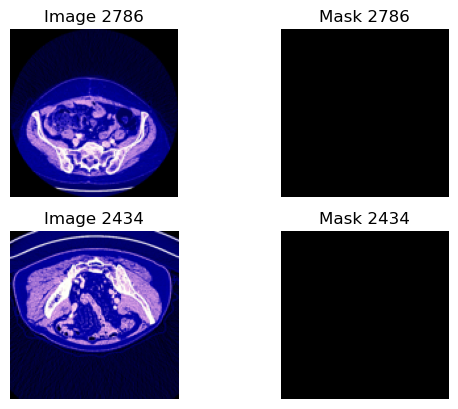

In [49]:
# Display two random images and masks
display_images_and_masks(train_images, train_masks)

# Hybrid Model

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, LayerNormalization, MultiHeadAttention, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import Policy, set_global_policy

# Set mixed precision policy for reduced memory usage
policy = Policy('mixed_float16')
set_global_policy(policy)

# Transformer Block
def transformer_block(x, num_heads=2, ff_dim=32):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output + x)

    ff_output = Dense(ff_dim, activation="relu")(attn_output)
    ff_output = Dense(x.shape[-1])(ff_output)
    return LayerNormalization(epsilon=1e-6)(ff_output + attn_output)

# Define the U-Net model architecture with attention and additional convolution layers
def unet_with_attention(input_layer):
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Apply transformer block
    pool1 = transformer_block(pool1)

    # Additional convolutional layer
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    up1 = UpSampling2D((2, 2))(conv3)
    concat1 = concatenate([conv2, up1], axis=-1)

    # Attention in decoder
    concat1 = transformer_block(concat1)
    
    # Further convolutional layers in decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    up2 = UpSampling2D((2, 2))(conv4)
    concat2 = concatenate([conv1, up2], axis=-1)

    # Output layer with a single filter and sigmoid activation
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(concat2)

    # Create the model instance with specified inputs and outputs
    model = Model(inputs=input_layer, outputs=outputs)
    return model

# Instantiate the U-Net model specifying the input shape
input_layer = Input(shape=(128, 128, 3), name='input_layer_1')
unet_model = unet_with_attention(input_layer)

# Compile the model
unet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
his1 = unet_model.fit(train_images, train_masks, batch_size=8, epochs=8, validation_data=(x_valid, y_valid))


Epoch 1/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3934s 3s/step - accuracy: 0.9829 - loss: 0.0493 - val_accuracy: 0.9853 - val_loss: 0.0380
Epoch 2/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4002s 4s/step - accuracy: 0.9898 - loss: 0.0227 - val_accuracy: 0.9877 - val_loss: 0.0270
Epoch 3/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3824s 3s/step - accuracy: 0.9922 - loss: 0.0127 - val_accuracy: 0.9894 - val_loss: 0.0269
Epoch 4/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3845s 3s/step - accuracy: 0.9932 - loss: 0.0061 - val_accuracy: 0.9895 - val_loss: 0.0328
Epoch 5/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3923s 3s/step - accuracy: 0.9937 - loss: 0.0043 - val_accuracy: 0.9913 - val_loss: 0.0131
Epoch 6/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3891s 3s/step - accuracy: 0.9948 - loss: 0.0013 - val_accuracy: 0.9891 - val_loss: 0.0335
Epoch 7/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3868s 3s/step - accuracy: 0.9947 - loss: -0.0016 - val_accuracy: 0.9902 - val_loss: 0.0269
Epoch 8/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3873s 3s/step - accuracy: 0.9950 - loss: 

In [52]:
!pip install spektral==1.0.6

  Attempting uninstall: spektral
    Found existing installation: spektral 1.3.1
    Uninstalling spektral-1.3.1:
      Successfully uninstalled spektral-1.3.1


In [53]:
import matplotlib.pyplot as plt

def plot_history(his1):
    # Plot the training loss values
    plt.plot(his1.history['loss'])
    # Plot the validation loss values
    plt.plot(his1.history['val_loss'])
    # Set the title of the plot to 'Model loss'
    plt.title('Model loss')
    # Set the y-axis label of the plot to 'Loss'
    plt.ylabel('Loss')
    # Set the x-axis label of the plot to 'Epoch'
    plt.xlabel('Epoch')
    # Add a legend to the plot with labels 'Train' for training loss and 'Validation' for validation loss
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot
    plt.show()


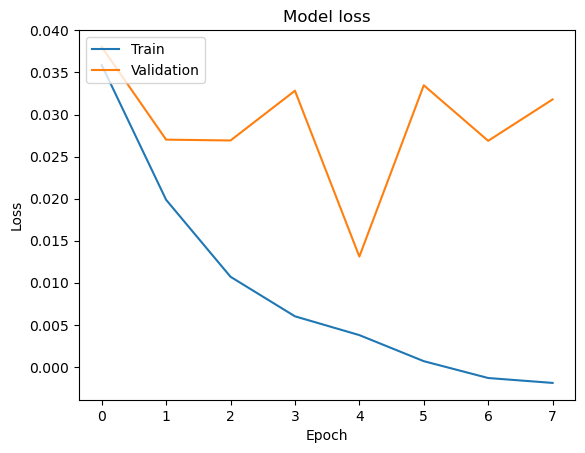

In [54]:
# Plotting the loss curve
plot_history(his1)

In [55]:
def plot_history(his1):
    # Plot the training loss values
    plt.plot(his1.history['accuracy'])
    # Plot the validation loss values
    plt.plot(his1.history['val_accuracy'])
    # Set the title of the plot to 'Model loss'
    plt.title('Model Accuracy')
    # Set the y-axis label of the plot to 'Loss'
    plt.ylabel('Loss')
    # Set the x-axis label of the plot to 'Epoch'
    plt.xlabel('Epoch')
    # Add a legend to the plot with labels 'Train' for training loss and 'Validation' for validation loss
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot
    plt.show()

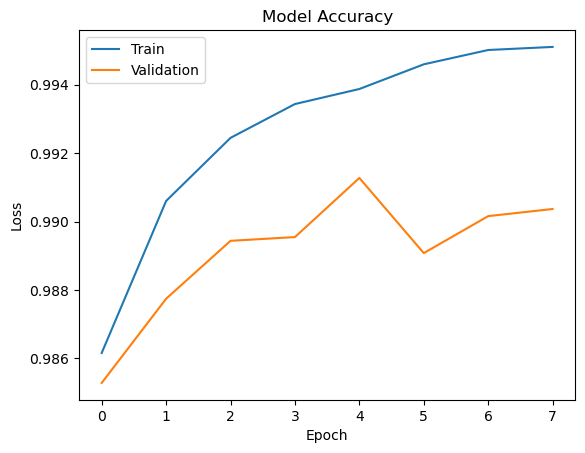

In [56]:
# Plotting the accuracy curve
plot_history(his1)

## 10.2 Evaluating Model

In [57]:
# Evaluate the performance of the trained U-Net model on the test dataset
evaluation = unet_model.evaluate(x_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 159s 9s/step - accuracy: 0.9923 - loss: 0.0164


In [58]:
accuracy = evaluation[1]

In [59]:
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.9911969304084778


## Making Prediction with Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


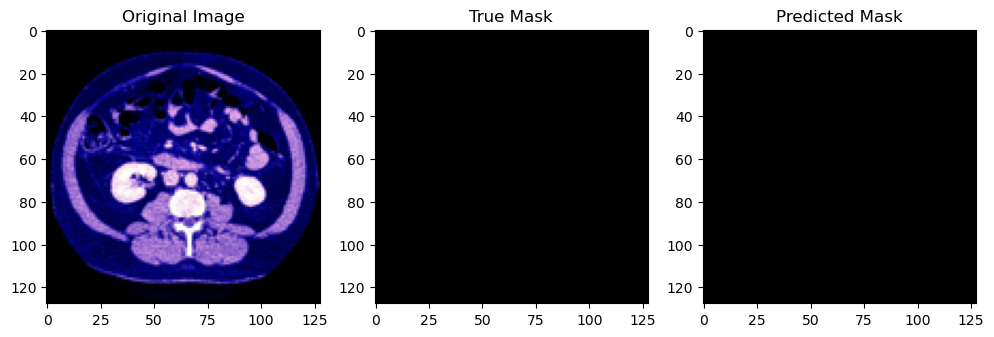

In [60]:
# Import the numpy library for numerical operations and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt

# Select an index for the image to be visualized and analyzed
image_index = 10

# Load the image and corresponding true mask from the test dataset
input_image = x_test[image_index]  # The input image to the model
true_mask = y_test[image_index]    # The ground truth mask for the input image

# Obtain the predicted mask from the U-Net model
predicted_mask = unet_model.predict(np.expand_dims(input_image, axis=0))[0]  # Model prediction for the input image

# Apply a threshold to convert the predicted mask to a binary mask
threshold = 0.5  
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)  # Binary version of the predicted mask

# Set up the plotting environment with a figure size
plt.figure(figsize=(12, 4))

# Plot the original image in the first subplot
plt.subplot(1, 3, 1)
plt.imshow(input_image)  # Display the original image
plt.title('Original Image')  # Title for the first subplot

# Plot the true mask in the second subplot
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')  # Display the true mask in grayscale
plt.title('True Mask')  # Title for the second subplot

# Plot the predicted binary mask in the third subplot
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')  # Display the binary predicted mask in grayscale
plt.title('Predicted Mask')  # Title for the third subplot

# Display the plots
plt.show()

In [61]:
import os

# Set the directories
train_images_dir = '/Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/train_images'
train_masks_dir = '/Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/train_masks'

# Get all the image filenames in the train_images_dir
train_image_files = sorted(os.listdir(train_images_dir))

# Select the first 10 image filenames
selected_images = train_image_files[:10]

# Print the full paths of the image and corresponding mask
for img_filename in selected_images:
    img_path = os.path.join(train_images_dir, img_filename)
    mask_filename = img_filename.replace('.jpg', '_mask.png')  # Assuming mask filenames have the '_mask' suffix
    mask_path = os.path.join(train_masks_dir, mask_filename)
    
    print(f"Image Path: {img_path}")
    print(f"Mask Path: {mask_path}")
    print()


Image Path: /Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/train_images/volume-100_slice_0.jpg
Mask Path: /Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/train_masks/volume-100_slice_0_mask.png

Image Path: /Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/train_images/volume-100_slice_10.jpg
Mask Path: /Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/train_masks/volume-100_slice_10_mask.png

Image Path: /Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/train_images/volume-100_slice_100.jpg
Mask Path: /Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/train_masks/volume-100_slice_100_mask.png

Image Path: /Users/sunkarabhavana/Downloads/TK168171 - Yashas - Liver Tumor Segmentation/BACKEND/train_images/volume-100_slice_102.jpg
Mask Path: /Users/sunkarabhavana/Downloads/TK1681

In [62]:
# Save the entire model
unet_model.save('unet_model_complete.h5')


In [63]:
# Save only the weights
unet_model.save_weights('unet_model_weights.weights.h5')


In [64]:
# Rebuild the architecture
input_layer = Input(shape=(128, 128, 3), name='input_layer_1')
unet_model = unet_with_attention(input_layer)

# Load weights
unet_model.load_weights('unet_model_weights.weights.h5')

# Optionally compile the model (for inference, this is not strictly necessary)
unet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [65]:
unet_model.summary()  # This will show the layers and confirm the architecture


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      1,792 │ cast_1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64,    │     16,640 │ max_pooling2d_2[… │
│ (MultiHeadAttentio… │ 64)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 64, 64,    │          0 │ multi_head_atten… │
│                     │ 64)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64,    │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64, 64,    │      2,080 │ layer_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64, 64,    │      2,112 │ dense_4[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 64, 64,    │          0 │ dense_5[0][0],    │
│                     │ 64)               │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64,    │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ layer_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ conv2d_6[0][0],   │
│ (Concatenate)       │ 256)              │            │ up_sampling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64,    │     65,984 │ concatenate_2[0]

 Total params: 475,649 (1.81 MB)

 Trainable params: 475,649 (1.81 MB)

 Non-trainable params: 0 (0.00 B)